# Market Model Example

This notebook demonstrates how to use the MarketModel class to calibrate a model and generate scenarios.

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import the MarketModel class
import sys
sys.path.append('..')  # Add parent directory to path
from src.models.market_model import MarketModel

## Load and Prepare Data

Load historical price data for CAC40 stocks.

In [10]:
# Create dictionary to store dataFrames for the 40 CAC40 companies
data_10y_dic = {}

# Get list of files containing 'Data' in the "Data/CAC40 daily 10y"
directory = "../Data/CAC40 daily 10y"
files = [f for f in os.listdir(directory) if 'Data' in f]

# Process each file
for file in files:
    # Get company name (first word before '_')
    company = file.split('_')[0]
    
    # Read the file with tab separator
    df = pd.read_csv(os.path.join(directory, file), sep='\t')
    
    # Convert first column to datetime and set as index
    df.index = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
    df = df.drop('date', axis=1)  # Remove the original date column
    df = df.dropna(axis=1, how='all') # Drop columns with all NaN values
    
    # Store in dictionary
    data_10y_dic[company] = df

# Create a DataFrame with all the closing prices
dfs = [df['clot'] for df in data_10y_dic.values()]
histo_CAC40 = pd.concat(dfs, axis=1, keys=data_10y_dic.keys())
histo_CAC40 = histo_CAC40.sort_index()

# Drop rows with NaN values
data = histo_CAC40.dropna()
print(f"Shape after dropping NaN rows: {data.shape}")
data.iloc[:5, :5]

Shape after dropping NaN rows: (1733, 40)


,PERNODRICARD,LVMH,THALES,TELEPERFORMANCE,ORANGE
date,,,,,
2018-06-05,144.00,309.60,108.70,136.5,14.620
2018-06-06,141.45,306.25,108.40,136.4,14.655
2018-06-07,140.50,296.15,108.05,136.7,14.670
2018-06-08,141.10,300.35,110.35,137.3,14.675
2018-06-11,141.90,301.15,109.60,137.4,14.805


## Create and Calibrate a Market Model

Create a Black-Scholes market model and calibrate it using historical data.

Model parameters:
Number of stocks: 40
Average annual return: 0.0438
Average annual volatility: 0.3052


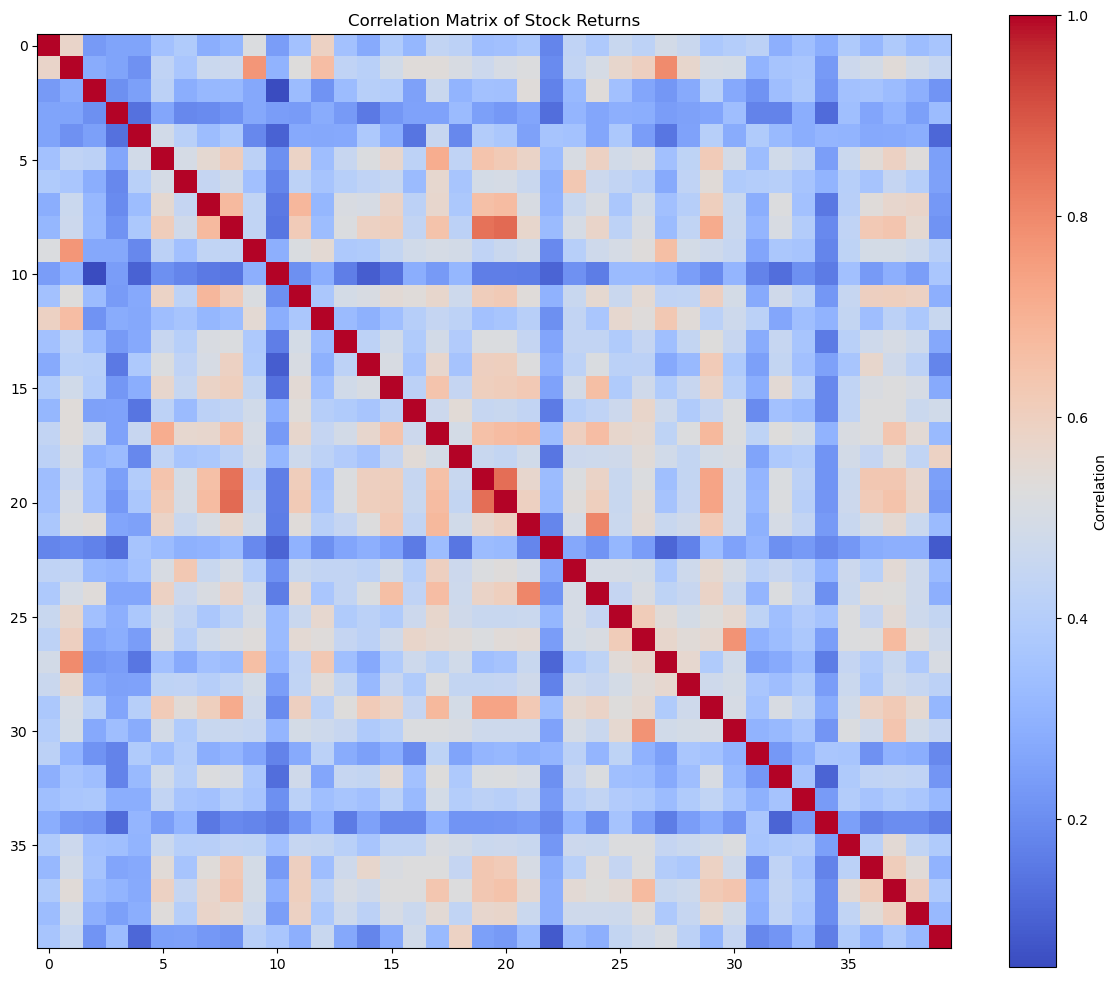

In [11]:
# Create a MarketModel object
market_model_BS = MarketModel(model_name="BS")

# Calibrate the model
market_model_BS.fit(data)

# Display model parameters
print("Model parameters:")
print(f"Number of stocks: {len(market_model_BS.parameters['Stocks'])}")
print(f"Average annual return: {market_model_BS.parameters['Returns'].mean():.4f}")
print(f"Average annual volatility: {market_model_BS.parameters['Volatilities'].mean():.4f}")

# Plot correlation matrix
plt.figure(figsize=(12, 10))
plt.imshow(market_model_BS.parameters['Correlation matrix'], cmap='coolwarm')
plt.colorbar(label='Correlation')
plt.title('Correlation Matrix of Stock Returns')
plt.tight_layout()
plt.show()

## Generate Scenarios

Generate scenarios of log-returns based on the calibrated model.

In [12]:
# Generate scenarios
begin_date = '2025-03-10'
end_date = '2026-03-10'
num_scenarios = 5

scenarios_BS = market_model_BS.generate_logreturns(begin_date, end_date, num_scenarios)

# Display the first scenario
print(f"Scenario 1 shape: {scenarios_BS['Scenario 1'].shape}")
scenarios_BS["Scenario 1"].iloc[:5, :5]

Scenario 1 shape: (262, 40)


,PERNODRICARD,LVMH,THALES,TELEPERFORMANCE,ORANGE
2025-03-10,-0.000000,0.000000,0.000000,-0.000000,0.000000
2025-03-11,0.011263,0.018256,-0.018608,0.005776,0.002814
2025-03-12,0.008603,-0.006630,0.016199,-0.016863,0.003343
2025-03-13,-0.013145,0.002839,0.022447,0.004100,0.011745
2025-03-14,-0.004564,0.007988,0.016756,-0.001118,-0.009633


## Visualize Scenarios

Plot the cumulative returns for each scenario.

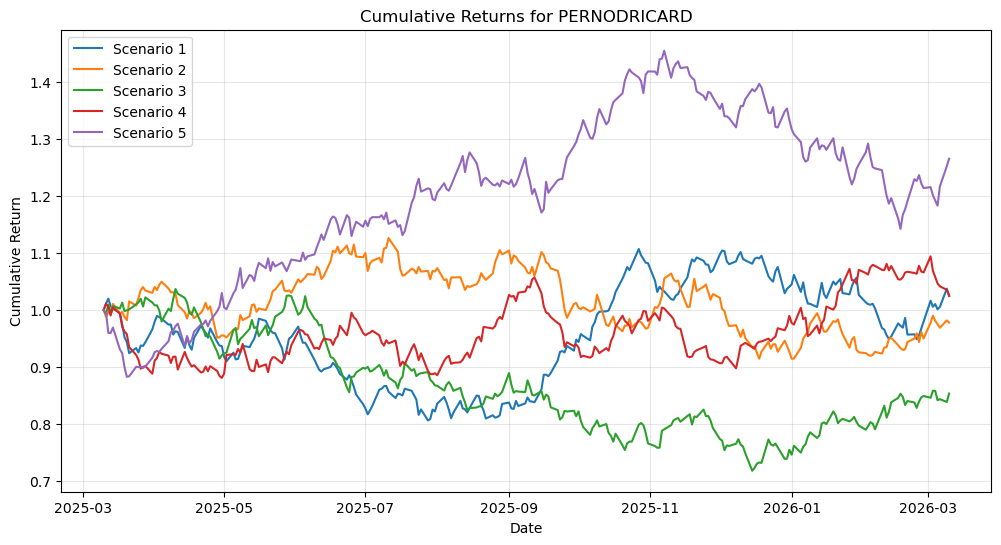

In [13]:
# Plot cumulative returns for the first stock in each scenario
plt.figure(figsize=(12, 6))

first_stock = market_model_BS.parameters['Stocks'][0]
for i in range(1, num_scenarios + 1):
    scenario = scenarios_BS[f'Scenario {i}']
    cumulative_returns = np.exp(np.cumsum(scenario[first_stock]))
    plt.plot(scenario.index, cumulative_returns, label=f'Scenario {i}')

plt.title(f'Cumulative Returns for {first_stock}')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()